In [57]:
%reload_ext autoreload
%autoreload 2
from Functions import *
from tqdm import tqdm

### First, some input that are used to initialize the beam (Gaussian)

In [2]:
''' Beam parameters '''
N = 4096			# number of sampling points
E0 = 9481			# photon energy [eV]
tau = 400			# pulse duration [fs]
window = 10000		# total simulation time window [fs]

''' OE parameters '''
hkl = [4,4,0]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 630
}

roc5 = 3.306122448979591e-3    # optimized radius of curvature for the "5mm lens"

### Then define beamline components

The beamline optics are defined in xraybeamline2d/optics1d. Note that the z-positions are defined in the lab frame.

    Optical elements used in this simulation:
      PPM (profile monitor)
      CRL: can be defined using either the targeted focal distance or the roc. Default material is Be.
      Crystal: the alphaAsym defines the angle of asymmetry, while the orientation is defined according to the direction
            in which the reflected beam turns toward: 0 -> +x, 1-> +y, 2 -> -x, 3 -> -y.
      Slit

In [3]:
def define_devices(roc, f1, f2, slit_width = 1e-3, hkl = [1,1,1], alphaAsym = 0., E0=18e3, f0 = 290., d23=7.):
    # viewing point upstream of monochromator
    im0 = optics.PPM('im0', z=870, FOV=5e-3, N=256)
    
    # collimation lens
    crl0 = optics.CRL('crl0', z=920, E0=E0, f=f0, diameter=2e-3)

    # first crystal: symmetric reflection
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                              alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    # second crystal: asymmetric reflection, orientation flipped relative to crystal1
    crystal2 = optics.Crystal('c2', hkl=hkl, length=10e-2, width=20e-3, z=crystal1.z+.2,
                              E0=E0,alphaAsym=alphaAsym, orientation=2,pol='s', delta=0e-6)
    
    # printing crystal incidence and reflection angles for confirmation
    print('crystal 2 incidence angle: {:.2f} degrees'.format(crystal2.alpha*180/np.pi))
    print('crystal 2 exit angle: {:.2f} degrees'.format(crystal2.beta0*180/np.pi))

    im_upstream = optics.PPM('im_upstream', z=crystal2.z + f1 - .1, FOV=2e-3, N=256)

    # CRL set 1, 1D focusing in horizontal
    crl1_1 = optics.CRL('crl1_1', z=crystal2.z+f1-.02, E0=E0, roc=200e-6,  diameter=5e-3)
    crl1_2 = optics.CRL('crl1_2', z=crystal2.z+f1-.01, E0=E0, roc=300e-6,  diameter=5e-3)
    crl1_3 = optics.CRL('crl1_3', z=crystal2.z+f1,     E0=E0, roc=300e-6,  diameter=5e-3)
    crl1_4 = optics.CRL('crl1_4', z=crystal2.z+f1+.01, E0=E0, roc=1000e-6, diameter=5e-3)
    crl1_5 = optics.CRL('crl1_5', z=crystal2.z+f1+.02, E0=E0, roc=roc, diameter=5e-3)

    # viewing point downstream of first crl
    im1 = optics.PPM('im1', z=crl1_3.z+.1,N=256,FOV=5e-3)

    # slit at focus
    slit = optics.Slit('slit', z=crl1_3.z+f2, x_width=slit_width, y_width=2e-3)

    # viewing point at focus
    focus = optics.PPM('focus', z=crl1_3.z+f2 + 1e-3, FOV=5e-3, N=256)

    # CRL set 2, for collimation
    crl2_1 = optics.CRL('crl2_1', z=crl1_3.z+2*f2-.02, E0=E0, roc=200e-6,  diameter=5e-3)
    crl2_2 = optics.CRL('crl2_2', z=crl1_3.z+2*f2-.01, E0=E0, roc=300e-6,  diameter=5e-3)
    crl2_3 = optics.CRL('crl2_3', z=crl1_3.z+2*f2,     E0=E0, roc=300e-6,  diameter=5e-3)
    crl2_4 = optics.CRL('crl2_4', z=crl1_3.z+2*f2+.01, E0=E0, roc=1000e-6, diameter=5e-3)
    crl2_5 = optics.CRL('crl2_5', z=crl1_3.z+2*f2+.02, E0=E0, roc=roc, diameter=5e-3)

    # third crystal, symmetric reflection, same orientation as crystal2
    crystal3 = optics.Crystal('c3', hkl=hkl, length=10e-2, width=10e-3, z=crl2_3.z+d23, E0=E0,alphaAsym=0, orientation=2,
                             asym_type='emergence',pol='s')

    # fourth crystal, asymmetric reflection, same orientation as crystal1
    crystal4 = optics.Crystal('c4', hkl=hkl, length=10e-2, width=10e-3, z=crl2_3.z+d23 + (f1-d23)*np.cos(crystal1.beta0*2),
                              E0=E0,alphaAsym=-alphaAsym, asym_type='emergence', orientation=0,pol='s')

    # viewing point just downstream of monochromator
    im2 = optics.PPM('im2', z=crystal4.z+.1, FOV=5e-3, N=256)

    # list of devices to propagate through
    devices = [im0, crl0, crystal1, crystal2, im_upstream,
               crl1_1, crl1_2, crl1_3, crl1_4, crl1_5, im1,
               slit, focus,
               crl2_1, crl2_2, crl2_3, crl2_4, crl2_5,
               crystal3,crystal4,im2]

    return devices

In [4]:
''' Define beamline '''
try: alphaAsym
except:
    crystal_temp = optics.Crystal('crystal', hkl=hkl, length=10e-2, width=20e-3, z=930, E0=E0,
                                  alphaAsym=0, orientation=0, pol='s', delta=0.e-6)

    alphaAsym = crystal_temp.alpha - np.deg2rad(5)      # calculate miscut angle (5 degree grazing incidence)

    if alphaAsym <= 0:
        print('\n***\n***\n*** Bragg angle smaller than grazing angle')

roc = roc5
f1 = 10.
f2 = 10.

devices = define_devices(roc,f1,f2,slit_width = 2000e-6, hkl = hkl,
                         alphaAsym = alphaAsym, E0=E0, f0 = 290., d23=7.)

b 1.00
b 1.00
b 11.28
crystal 2 incidence angle: 80.86 degrees
crystal 2 exit angle: 5.02 degrees
b 1.00
b 0.09


### Initialize beam and propagate through beamline

The beam is defined in xraybeamline2d/beam1d, in which class Pulse() and Beam() refer to beam with/without time components.

Note: when propagating the beam, at least one PPM is needed for field evaluation.

In [5]:
%%capture capt
''' propagate '''
mono_beamline = beamline.Beamline(devices)

tstart = time.time()
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)

screen_names = ['im0','im_upstream','im1','focus','im2']
part_names = ['1.incidence','2.before_crl1','3.after_crl1','4.focus','5.output']
pulse.propagate(beamline=mono_beamline, screen_names=screen_names)
tfin = time.time()

In [6]:
print('propagation lasted {}s'.format(round(np.round(tfin-tstart),2)))

propagation lasted 10.0s


### Plots

The common ways of examining the beam profiles in space, time and energy domain:
    
    pulse.plot_spectrum(image_name), which shows the spectrum (at 0,0)
    pulse.plot_pulse(image_name), which shows the pulse structure (at 0,0)
    pulse.imshow_projection(image_name), which shows the integrated intensity in xy
    pulse.imshow_time_slice(image_name, dim='x', slice_pos=0, shift=0.), which shows a slice along space and time
    pulse.imshow_energy_slice(image_name, dim='x', slice_pos=0), which shows a slice along space and energy
   etc.

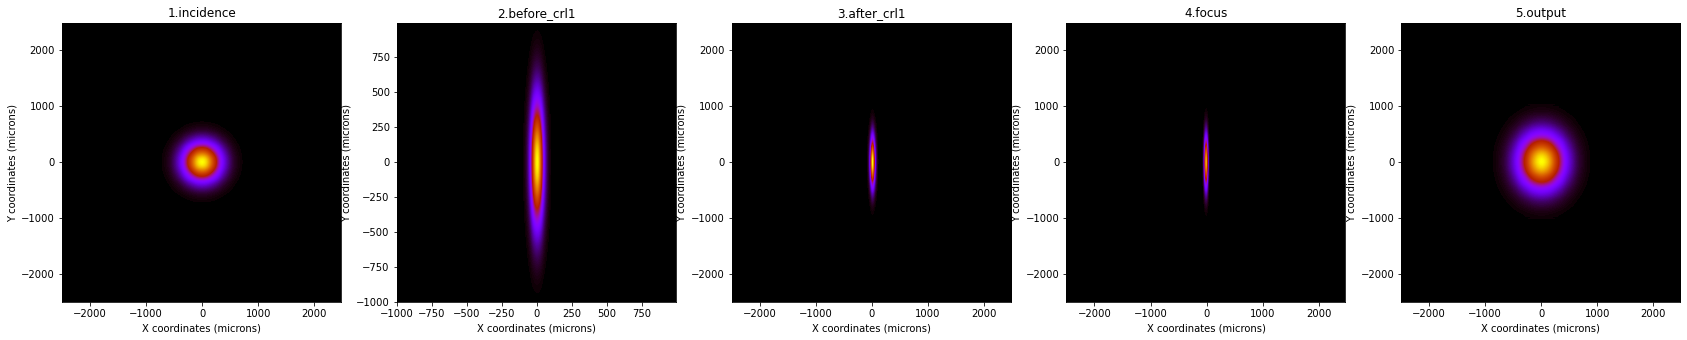

In [44]:
''' spatial profiles '''
plot_profiles_all(pulse, screen_names, part_names)

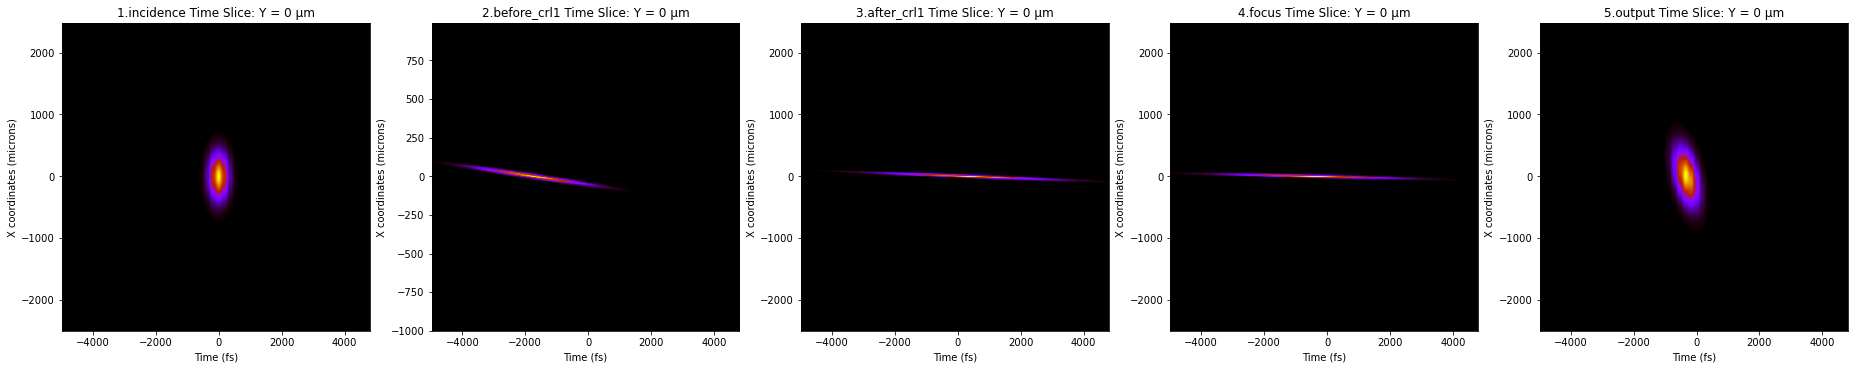

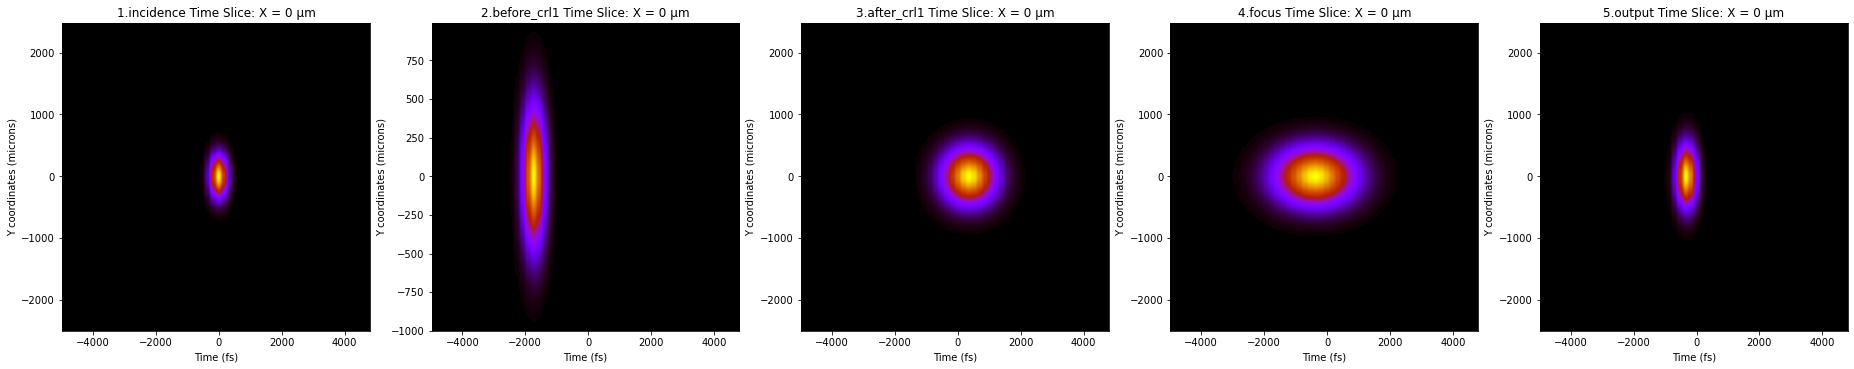

In [54]:
''' time slices '''
for dim in ['x','y']:
    plot_Tslice_all(pulse, screen_names, part_names, dim)

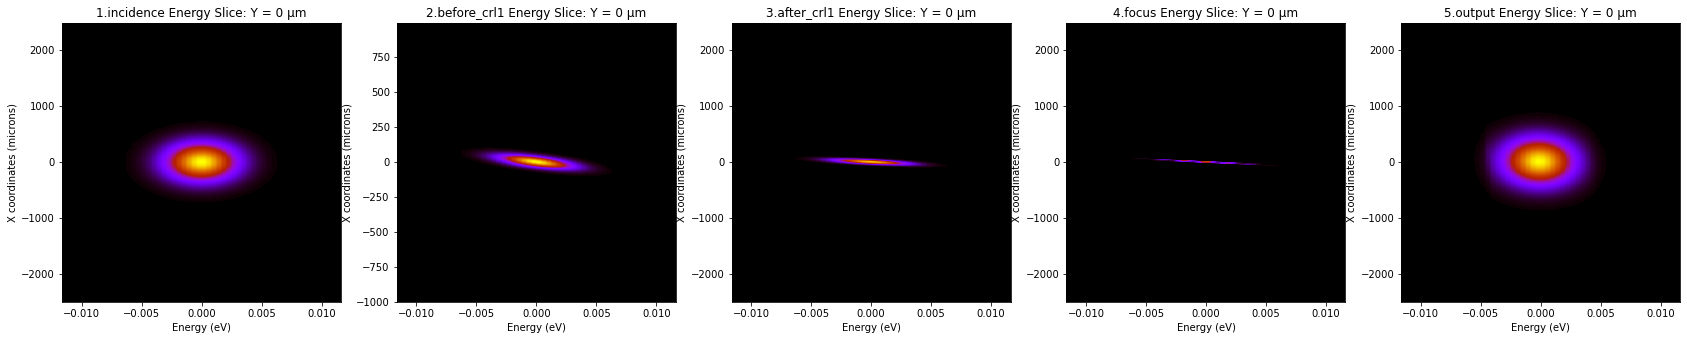

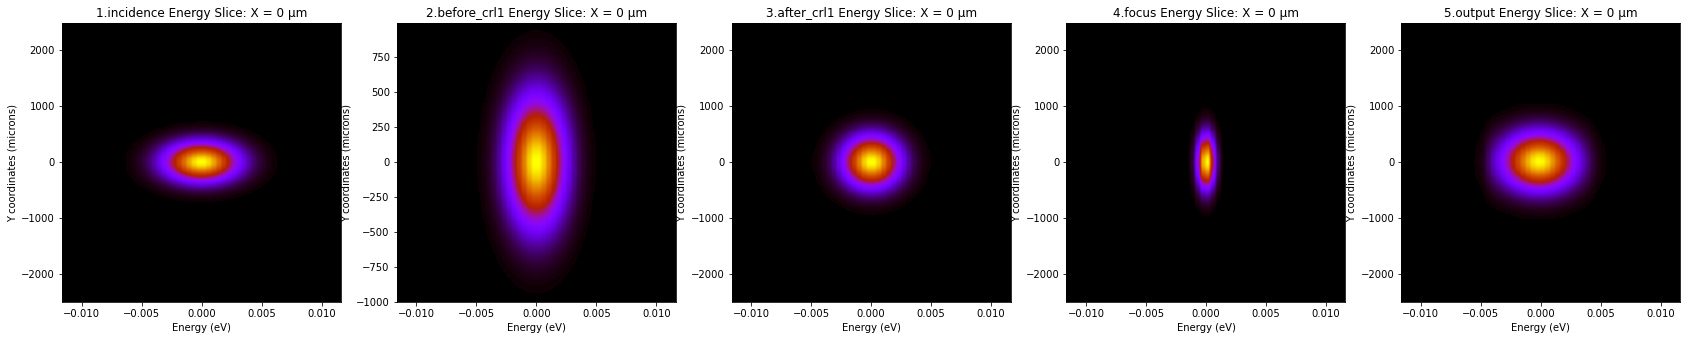

In [58]:
''' energy slices '''
for dim in ['x','y']:
    plot_Eslice_all(pulse, screen_names, part_names, dim)

In [10]:
import winsound
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)